# Test New Data Insertion

Following extensive discussions with Raph and Aakash ([#323](https://github.com/CityofToronto/bdit_data-sources/issues/323), [#329](https://github.com/CityofToronto/bdit_data-sources/issues/329)), made a few changes to `intersection_tmc.py`. Miovision made changes to their API in summer 2020 (Mohan Thomas e-mail June 30, 2020 4:58 PM) that:
- Moved streetcar counts from buses to general unsorted motorized vehicles.
- Folded work vans into light autos.

We need to find an intersection with missing data as close to September 2020 as possible, to avoid conflicts. Happily, the one Raph found (Danforth / Woodbine; `uid = 38`, `id = 6174c193-13a9-4056-832b-f80783eaf333`) has has missing data in late August and no work vans:

```sql
SELECT COUNT(*)
FROM miovision_api.volumes
WHERE intersection_uid = 38 AND classification_uid = 8 AND datetime_bin BETWEEN '2020-08-22 00:00:00' AND '2020-08-24 00:00:00';
```

returns 0.

In [1]:
import psycopg2
import math
import pytz
import datetime
import dateutil
import requests
import json
import pandas as pd
import pathlib
import configparser

In [2]:
# Grab Postgres and Miovision credentials.
config = configparser.ConfigParser()
config.read(pathlib.Path.home().joinpath('.charlesconfig').as_posix())
postgres_settings = config['POSTGRES']
miov_token = config['MIOVISION']['key']

local_tz = pytz.timezone('US/Eastern')

url = 'https://api.miovision.com/intersections/' 
tmc_endpoint = '/tmc'

## Diagnostic Functions

Functions to extract data from the Miovision API into Pandas. Based off of discussion and code snippets in [#323](https://github.com/CityofToronto/bdit_data-sources/issues/323).

In [3]:
headers = {'Content-Type':'application/json', 'Authorization': miov_token}

# Generator for cycling through 6-hour time blocks.
def timerange(start_time, end_time, dt):
    for i in range(math.ceil((end_time - start_time) / dt)):
        c_start = start_time + i * dt
        c_end = min(c_start + dt, end_time)
        yield (c_start, c_end)


def get_raw_api_call(start_time, end_time, dt, intersection_id):
    tmc_all = []

    for (c_start_t, c_end_t) in timerange(start_time, end_time, dt):
        params = {'endTime': c_end_t, 'startTime' : c_start_t} 
        response=requests.get(url + intersection_id + tmc_endpoint,
                              params=params, headers=headers)
        tmc = json.loads(response.content.decode('utf-8'))
        tmc_all += tmc
    return tmc_all

In [4]:
# Functions from intersections_tmc.py for encoding movement and class.
def get_movement(entrance, exit_dir):
    if (entrance == 'N' and exit_dir =='S'):
        return '1'
    elif entrance == 'S' and exit_dir =='N':
        return '1'
    elif entrance == 'W' and exit_dir =='E':
        return '1'
    elif entrance == 'E' and exit_dir =='W':
        return '1'
    elif entrance == 'S' and exit_dir =='W':
        return '2'
    elif entrance == 'N' and exit_dir =='E':
        return '2'
    elif entrance == 'W' and exit_dir =='N':
        return '2'
    elif entrance == 'E' and exit_dir =='S':
        return '2'
    elif entrance == 'S' and exit_dir =='E':
        return '3'
    elif entrance == 'E' and exit_dir =='N':
        return '3'
    elif entrance == 'N' and exit_dir =='W':
        return '3'
    elif entrance == 'W' and exit_dir =='S':
        return '3'
    return '4'

def apply_get_movement(row):
    return get_movement(row["entrance"], row["exit"])

def get_classification(veh_class):
    if (veh_class == 'Pedestrian'):
        return '6'
    elif veh_class == 'Light':
        return '1'
    elif veh_class == 'Bicycle':
        return '2'
    elif veh_class == 'Bus':
        return '3'
    elif veh_class == 'SingleUnitTruck':
        return '4'
    elif veh_class == 'ArticulatedTruck':
        return '5'
    elif veh_class == 'WorkVan':
        return '8'
    elif veh_class == 'MotorizedVehicle':
        return '9'
    raise ValueError("vehicle class {0} not recognized!".format(veh_class))

# Convert to Pandas DataFrame.
def convert_raw_api_to_df(tmc_all):
    df_tmc = pd.DataFrame(tmc_all)
    df_tmc["movement_uid"] = df_tmc.apply(apply_get_movement, axis=1).astype(int)
    df_tmc["classification_uid"] = df_tmc["class"].apply(get_classification).astype(int)
    df_tmc['datetime_bin'] = pd.to_datetime(df_tmc['timestamp']).dt.tz_convert(local_tz)
    df_tmc.rename(columns={'qty': "volume"}, inplace=True)
    df_tmc["leg"] = df_tmc["entrance"]
    df_tmc['in_api'] = True
    return df_tmc

## Experiment

### Postgres Bulk Statistics Before Data Refresh

Before we try to fill missing values with `intersection_tmc.py`, alter the classification IDs of class 0 counts to class 9:

```sql
UPDATE miovision_api.volumes
SET classification_uid = 9
WHERE intersection_uid = 38 AND classification_uid = 0 AND datetime_bin BETWEEN '2020-08-22 00:00:00' AND '2020-08-24 00:00:00';
```

There are 82 class 9 vehicles during this time.

Before updating the data, the command

```sql
SELECT COUNT(*)
FROM miovision_api.volumes
WHERE intersection_uid = 38 AND classification_uid != 6 AND datetime_bin BETWEEN '2020-08-22 00:00:00' AND '2020-08-24 00:00:00'
```

returns 18367

```sql
SELECT COUNT(DISTINCT datetime_bin)
FROM miovision_api.volumes
WHERE intersection_uid = 38 AND classification_uid != 6 AND datetime_bin BETWEEN '2020-08-22 00:00:00' AND '2020-08-24 00:00:00'
```

returns 2190, a far cry from the 2881 we'd expect from two full days plus midnight on the third day.

```sql
SELECT classification_uid, COUNT(*)
FROM miovision_api.volumes
WHERE intersection_uid = 38 AND classification_uid != 6 AND datetime_bin BETWEEN '2020-08-22 00:00:00' AND '2020-08-24 00:00:00'
GROUP BY classification_uid
ORDER BY classification_uid
```

gives

```
1	14623
2	2493
3	766
4	390
5	13
9	82
```

How does that compare with the API?

### API Bulk Statistics

In [5]:
# Extract all non-pedestrian values using the Miovision API from 2020-08-22
# to 2020-08-24 (inclusive) with a cadence of 6 hours.
start_time = local_tz.localize(datetime.datetime(2020, 8, 22))
end_time = local_tz.localize(datetime.datetime(2020, 8, 24, 0, 1, 0))
dt = datetime.timedelta(hours=6)
# Equivalent to intersection_uid = 38
intersection_id = "6174c193-13a9-4056-832b-f80783eaf333"

In [6]:
raw_tmc = get_raw_api_call(start_time, end_time, dt, intersection_id)
df_tmc = convert_raw_api_to_df(raw_tmc)

In [7]:
df_tmc["datetime_bin"].unique().shape

(2876,)

In [8]:
df_tmc["classification_uid"].value_counts()

1    19989
2     3156
3      962
4      447
9       90
5       16
Name: classification_uid, dtype: int64

So we have way more vehicles in every category.

### Run Data Refresh

Run

```
python intersection_tmc.py run-api --path /etc/airflow/data_scripts/volumes/miovision/api/config.cfg --start_date 2020-08-22 --end_date 2020-08-24 --intersection 38
```

Now

```sql
SELECT COUNT(*)
FROM miovision_api.volumes
WHERE intersection_uid = 38 AND classification_uid != 6 AND datetime_bin BETWEEN '2020-08-22 00:00:00' AND '2020-08-24 00:00:00'
```

returns 24660

```sql
SELECT COUNT(DISTINCT datetime_bin)
FROM miovision_api.volumes
WHERE intersection_uid = 38 AND classification_uid != 6 AND datetime_bin BETWEEN '2020-08-22 00:00:00' AND '2020-08-24 00:00:00'
```

returns 2876

```sql
SELECT classification_uid, COUNT(*)
FROM miovision_api.volumes
WHERE intersection_uid = 38 AND classification_uid != 6 AND datetime_bin BETWEEN '2020-08-22 00:00:00' AND '2020-08-24 00:00:00'
GROUP BY classification_uid
ORDER BY classification_uid
```

returns

```
1	19989
2	3156
3	962
4	447
5	16
9	90
```

These stats are identical to the API ones! We just need to check that the data are indeed now the same using a row-by-row join.

In [9]:
# Retrieve data from the Postgres raw data.
sql_query = """SELECT *
FROM miovision_api.volumes
WHERE intersection_uid = 38 AND classification_uid != 6 AND datetime_bin BETWEEN '2020-08-22 00:00:00' AND '2020-08-24 00:00:00'
"""

with psycopg2.connect(database='bigdata', **postgres_settings) as db_con:
    df_pg = pd.read_sql(sql_query, db_con)
    df_pg['datetime_bin'] = df_pg['datetime_bin'].dt.tz_localize(local_tz)
    df_pg['in_postgres'] = True
    df_pg['new_insert'] = df_pg['volume_uid'] >= 700000000

# Merge all unique
df_combined = pd.merge(
    df_pg[['datetime_bin', 'classification_uid', 'leg', 'movement_uid',
           'volume', 'in_postgres', 'volume_uid', 'new_insert']],
    df_tmc[['datetime_bin', 'classification_uid', 'leg', 'movement_uid', 'volume', 'in_api']],
    how="outer",
    on=['datetime_bin', 'classification_uid', 'leg', 'movement_uid', 'volume'])
df_combined.sort_values(['datetime_bin', 'classification_uid', 'leg', 'movement_uid', 'volume'], inplace=True)

In [19]:
df_combined.loc[df_combined['in_postgres'].isna(), :]

,datetime_bin,classification_uid,leg,movement_uid,volume,in_postgres,volume_uid,new_insert,in_api
24660,2020-08-22 17:41:00-04:00,1,N,3,4,NaN,NaN,NaN,True


In [18]:
df_combined.loc[df_combined['in_api'].isna(), :]

,datetime_bin,classification_uid,leg,movement_uid,volume,in_postgres,volume_uid,new_insert,in_api
4960,2020-08-22 17:41:00-04:00,1,N,3,3,True,753228023.0,True,NaN


In [12]:
df_combined.loc[~df_combined['in_api'].isna() & ~df_combined['in_postgres'].isna(), 'classification_uid'].value_counts()

1    19988
2     3156
3      962
4      447
9       90
5       16
Name: classification_uid, dtype: int64

<IPython.core.display.Javascript object>


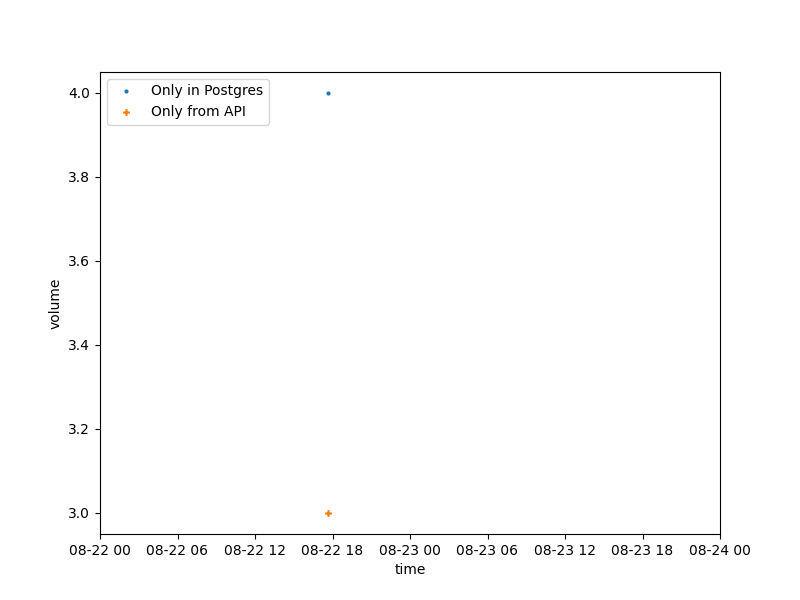

In [14]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(df_combined.loc[df_combined['in_postgres'].isna(), 'datetime_bin'],
        df_combined.loc[df_combined['in_postgres'].isna(), 'volume'], ms=2, marker="o", ls="none",
        label="Only in Postgres")
ax.plot(df_combined.loc[df_combined['in_api'].isna(), 'datetime_bin'],
        df_combined.loc[df_combined['in_api'].isna(), 'volume'], ms=2, mew=5, marker="+", ls="none",
        label="Only from API")
ax.set_xlabel("time")
ax.set_ylabel("volume")
ax.set_xlim([df_combined['datetime_bin'].min(), df_combined['datetime_bin'].max()])
ax.legend(loc=2);

So there is still a single difference between API and Postgres - a count of 4 instead of 3 light vehicles in on `2020-08-22 17:41:00-04:00`.